In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical 
from keras.callbacks import EarlyStopping
%matplotlib inline

In [23]:
df = df = pd.read_csv('Cleaned_tweets.csv')
df.head()

,Unnamed: 0,Key Word,Username,User_ID,Datetime,Favorite_count,Geo,Coordinates,Label,Text,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,704,ass,DeborahParr,1.330000e+18,11-11-2020 06:56,0,NaN,NaN,1,He’d have my phone wedged up his ass sideways.,NaN,NaN,NaN
1,1915,boobies,MaxZorin85,1.330000e+18,11-11-2020 07:35,4,NaN,NaN,0,Yep 100% agree and the same with severine in s...,NaN,NaN,NaN
2,2856,eat pussy,PRISJ1_,1.330000e+18,11-11-2020 10:36,0,NaN,NaN,1,Stop having sex with men that won’t eat your p...,NaN,NaN,NaN
3,2163,Breast Man,Teresamckenzy1,1.330000e+18,10-11-2020 20:52,0,NaN,NaN,1,"When you see a sad man, just give him breast t...",NaN,NaN,NaN
4,2852,eat pussy,sj__vazquez,1.330000e+18,11-11-2020 10:42,0,NaN,NaN,1,We can't be together if you don't eat pussy,NaN,NaN,NaN


In [24]:
del df['Username']
del df['Key Word']
del df['User_ID']
del df['Datetime']
del df['Favorite_count']
del df['Geo']
del df['Coordinates']
del df['Unnamed: 11']
del df['Unnamed: 9']
del df['Unnamed: 10']
df.columns = ['Unnamed','Label', 'Text']
del df['Unnamed']
df.head()

,Label,Text
0,1,He’d have my phone wedged up his ass sideways.
1,0,Yep 100% agree and the same with severine in s...
2,1,Stop having sex with men that won’t eat your p...
3,1,"When you see a sad man, just give him breast t..."
4,1,We can't be together if you don't eat pussy


In [25]:
X = df.Text
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [26]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [27]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [28]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [29]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [30]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [31]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
20/20 [==============================] - 7s 228ms/step - loss: 0.6853 - accuracy: 0.5434 - val_loss: 0.6588 - val_accuracy: 0.6378
Epoch 2/10
20/20 [==============================] - 4s 210ms/step - loss: 0.6169 - accuracy: 0.6831 - val_loss: 0.5949 - val_accuracy: 0.6803
Epoch 3/10
20/20 [==============================] - 4s 210ms/step - loss: 0.4837 - accuracy: 0.7645 - val_loss: 0.5819 - val_accuracy: 0.6884
Epoch 4/10
20/20 [==============================] - 4s 207ms/step - loss: 0.4287 - accuracy: 0.7998 - val_loss: 0.5018 - val_accuracy: 0.7520
Epoch 5/10
20/20 [==============================] - 4s 210ms/step - loss: 0.3706 - accuracy: 0.8397 - val_loss: 0.5557 - val_accuracy: 0.7210


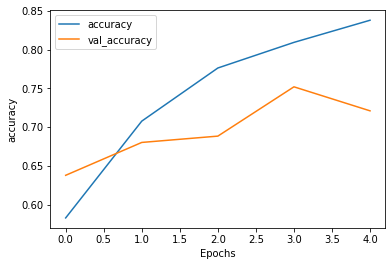

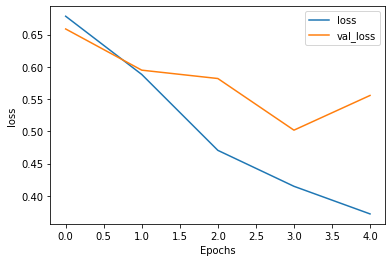

In [32]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [33]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [34]:
accr = model.evaluate(test_sequences_matrix,Y_test)

17/17 [==============================] - 0s 24ms/step - loss: 0.5585 - accuracy: 0.7153


In [35]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.558
  Accuracy: 0.715


In [36]:
y_pred = model.predict(test_sequences_matrix)

In [40]:
from sklearn.metrics import f1_score
print(f1_score(Y_test, y_pred.round(), average='macro'))
print(f1_score(Y_test, y_pred.round(), average='micro'))
print(f1_score(Y_test, y_pred.round(), average='weighted'))
print(f1_score(Y_test, y_pred.round(), average=None))
print(f1_score(Y_test, y_pred.round(), zero_division=1))

0.702832073048937
0.7153419593345656
0.7085798586396314
[0.64186047 0.76380368]
0.763803680981595


In [41]:
from sklearn.metrics import recall_score
print(recall_score(Y_test, y_pred.round(), average='macro'))
print(recall_score(Y_test, y_pred.round(), average='micro'))
print(recall_score(Y_test, y_pred.round(), average='weighted'))
print(recall_score(Y_test, y_pred.round(), average=None))
print(recall_score(Y_test, y_pred.round(), average=None, zero_division=1))

0.7022407611693327
0.7153419593345656
0.7153419593345656
[0.56326531 0.84121622]
[0.56326531 0.84121622]


In [42]:
from sklearn.metrics import precision_score
print(precision_score(Y_test, y_pred.round(), average='macro'))
print(precision_score(Y_test, y_pred.round(), average='micro'))
print(precision_score(Y_test, y_pred.round(), average='weighted'))
print(precision_score(Y_test, y_pred.round(), average=None))
print(precision_score(Y_test, y_pred.round(), average=None, zero_division=1))

0.7226920740965685
0.7153419593345656
0.7204999346061466
[0.74594595 0.6994382 ]
[0.74594595 0.6994382 ]
